<a href="https://colab.research.google.com/github/musicjae/cs231n/blob/master/assignment3/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving r4.png to r4.png
User uploaded file "r4.png" with length 161032 bytes


In [23]:
from IPython.display import Image

# RNN (1)  
  
  ## 1. RNN 소개

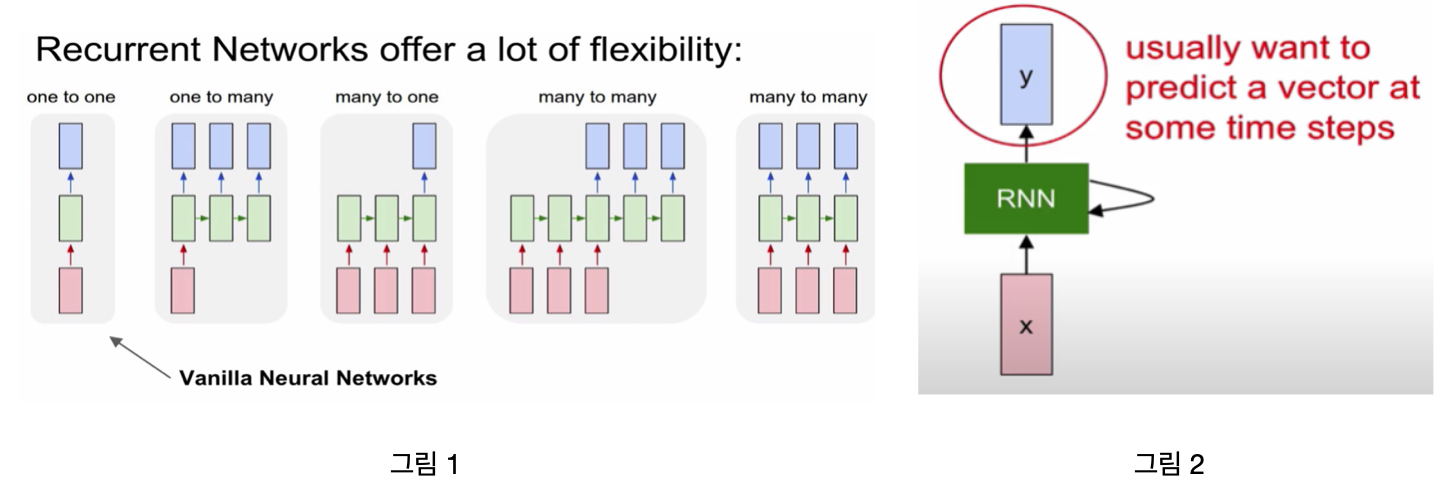

In [18]:
Image('r6.png', width = 1000)

우리가 기존에 다뤘던 신경망은 위 [그림1]의 맨 왼쪽에 있는 형태를 지닌다. 이번 글에서 우리가 알아볼 RNN은 그것의 오른쪽에 있는 것들처럼 여러 형태를 지닐 수 있다. RNN은 하나의 입력값으로 여러 개의 출력값을 산출시킬 수도 있고, 여러 개의 입력값으로 단 하나의 출력값을 산출시킬 수도 있다. 이런 형태의 RNN은 이미지 캡셔닝, 감정 분류, (many to many 경우에) 기계 번역 과제에서 사용되곤 한다.  
  
  (1) **시간성, 순차성**: RNN은 시간성 temporal property를 가진 데이터를 처리하는 데 유용하다. 이것은 주식 시세 변동, 음성 신호, 문장 처리 등을 다룰 때 빈번히 사용된다. 이런 시간성 데이터를 처리할 때, 시간 t-n의 어떤 상태를 가진 데이터를 처리한 뒤 시간 t-n+1의 어떤 다른 상태를 가진 데이터를 처리하듯이, **순차적으로** 데이터를 처리한다는 의미에서, 이 시간성 데이터를 순차 데이터라고 간주하기도 한다.  


   
  
  (2) **순환성**: [그림2]는 RNN의 특징을 잘 보여준다. RNN이 'Recurrenct Neural Networks'의 약자라는 점이 암시하듯이, 이것의 특징은 순환적이다. [그림2]를 참고해보면, 매 timestep 마다 x 입력값을 받는 RNN이 있다. 이것은 내부적으로 어떤 상태를 갖는데, 이것은 매 시간마다 입력값을 받는 여러 은닉층으로 구성되어 있다. 이 RNN 단계에서 가중치는 시간 스텝이 갱신될 때마다 업데이트되는데, 그럼으로써 새로운 입력값이 들어올 때마다 다른 출력값을 제공한다.결과적으로, 우리는 이런 과정을 거친 뒤 특정 timestep에서 어떤 벡터를 예측하고자 한다.


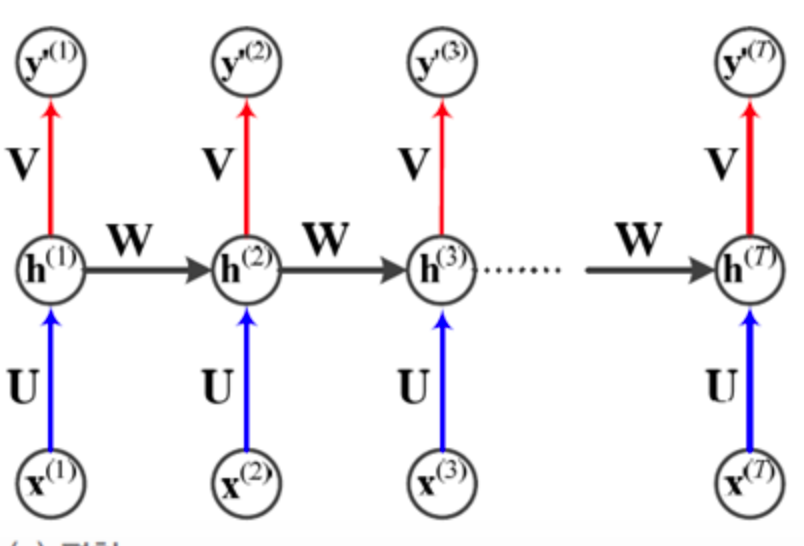

In [16]:
Image('r8.png', width= 400)

(3) **매개변수 공유**: 위 그림에서 나타나듯이, (이 경우에는) 모든 timestep 에서 모두 동일한 매개변수(U, W, V)를 사용하고 있다. 이것은 CNN에서 매개변수를 공유하듯이, RNN에서도 매개변수를 공유한다는 것을 보여준다. 분명 이것은 메모리 절약 측면에서 매우 좋은 이점이다. FC-Net 경우에, 입력 데이터가 매우 크면, e.g. 처리할 단어 수가 10만 개이고, 시퀀스 길이가 100이라면, FCnet은 첫번째 은닉층을 계산하기 위해 1000만 개의 매개변수를 처리해야 한다. 하지만 CNN에서 처럼, RNN에서도 이 매개변수 공유를 통해 처리할 매개변수의 개수를 상당히 줄일 수 있다.  
- U: [ 입력값 --> 은닉층]인 엣지edge 가중치
- W: [은닉층 --> 은닉층]인 순환 edge 가중치  
- V: [은닉층 --> 출력값]인 edge 가중치
- (bias): 항상 값이 1인 바이어스 노드와 연결된 가중치 


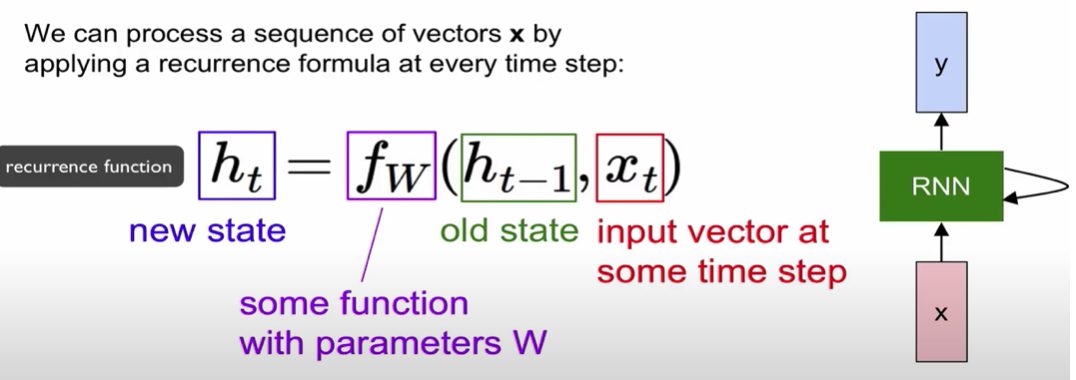

In [13]:
Image('r7.png')

RNN에서 우리는 위의 식 같은 순환 함수를 사용한다. 이것은 시퀀스sequence를 처리하는 데 유용하다.  
이 함수가 의미하는 바는 다음과 같다:   
- 이 함수는 <파라미터 w에 대한 함수>, <직전 시점에 은닉 스텝>, <현재 시점에 입력값 인자>로 이루어진다.  
- 이것은 파라미터 w에 대한 함수이니까, w를 업데이트시킨다.  
- 따라서, (우리가 주어진 목적에 부합하도록) 새로운 상태 ht를 얻을 수 있도록 가중치 W 값을 학습시켜 나간다.  
 

RNN은 시퀀스sequence, e.g, $x^{(1)}, ..., x^{(\tau)}$, 를 처리하는 데 특화된 신경망이다. 고전적인 형태의 동역학계 dynamical system을 가지고 이것의 이해를 더해보자.  
  
  $$s^{(t)} = f(s^{(t-1)}; \theta)$$  
    
$s^{(t)}$는 계의 현재 상태를 지칭한다. 위 식의 특징은 시간 t에서의 s에 대한 정의가 이전 시간 t-1에서의 그 자신 (동일한 정의 s)을 재귀적으로 참조한다는 것이다. 이것은 소위 점화식 recurrence formula라고 불린다.  
시간 단계의 수 $\tau$가 유한한 경우에 이 정의를 $\tau-1$번 적용해서 그래프를 펼친unfolding다. 예를 들어, $\tau = 3$인 경우엔 다음과 같다:  
$$ s^{(3)} = f(s^{(2)}; \theta) = f(f(s^{(1)}; \theta) ; \theta)$$ 
  
  $\tau = 3$인 경우에, 우리는 $\tau=2$인 경우를 인자로 사용한다. 그리고 다시 $\tau=2$인 경우에는 그것이 1인 경우를 그 인자로 사용한다  


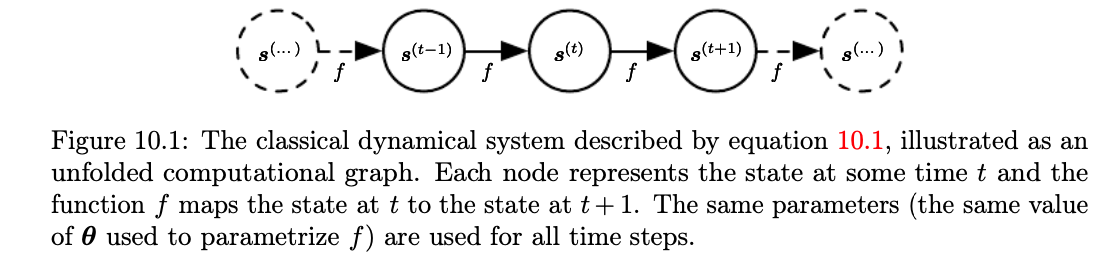

In [3]:
Image('r1.png')

또 다른 예를 보자. 이번에는 외부 신호 $x^{(t)}$가 이끄는 동역학계를 생각해보자. 이 경우 식은 아래와 같다:  
 $$s^{(t)} = f(s^{(t-1)}, x^{(t)}; \theta)$$  
 여기서 $\theta$는 가중치들(U, V, ...)과 bias로 구성된다.
 이 식 역시도 동역학계의 상태는 과거의 모든 정보를 포함한다는 것을 보여준다.  
   
 위 동역학 식을 신경망의 은닉 단위unit의 상태를 나타내는 식으로 다시 표현해보자. h는 은닉 unit을 지칭한다.  
  
$$h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$$  
일반적으로, 이전 시간의 입력 순차열을 요약해주는 함수 $h^{(t)}$는 임의의 길이 순차열 ${x^{(t)}}$, ..., $x^{(1)}$를 고정 길이 벡터 $h^{(t)}$에 사상하므로, 손실이 있을 수 있다는 점에 유의하자.  

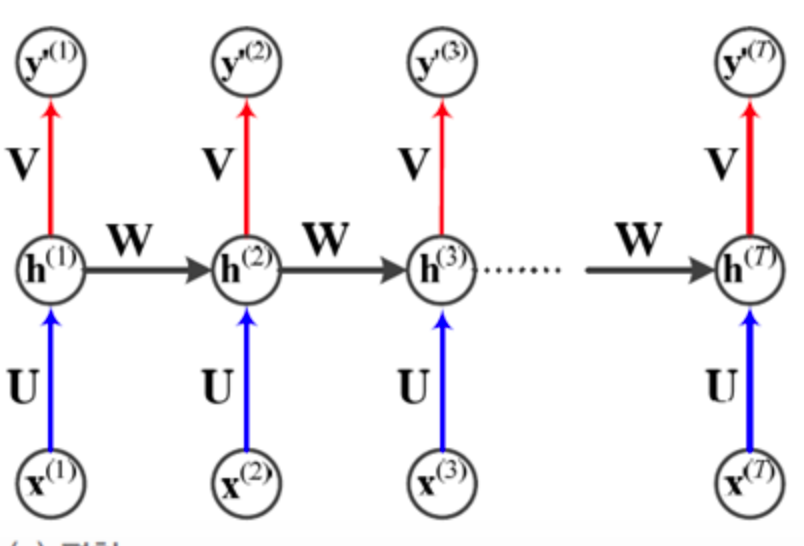

In [20]:
Image('r8.png',width=400)

위에서 본 그림을 다시 활용하여 활성화 함수로 tanh를 사용한다고 가정할 때 위의 식 $h^{(t)}$를 다시 표현해보면 다음과 같다:  

(1) 현재 시간 은닉층:  

$$ h^{(t)} = tanh(W_{hh}h_{t-1} + U_{xh}x^{(t)}+b)$$  
(2) 출력층:  
$$o^{t} = V_{hy}+b$$
$$예측값\ \ \ y' = softmax(o^{(t)})$$

 
이런 순환 신경망 RNN은 2 가지 방식으로 그래프화될 수 있다.   

(1) 모형의 물리적 구현(e.g. 인간의 뇌에 있는 생물학적 신경망)에 있을만한 각 구성요소를 개별 노드로 두는 것.  
이 신경망은 실시간으로 작동하는 하나의 회로를 정의한다.  

(2) 위 (1)을 펼쳐진**unfolding** 계산 그래프로 표현하는 것이다. 이 경우 각 구성요소는 여러 변수로 표현되고, 하나의 시간 스텝에 대한 변수는 특정 시점에 구성요소의 상태를 표현한다.  
  
이 두 표현은 각자 나름의 쓸모가 있다: (1) 같은 순환 그래프는 수행할 계산을 명시적으로 표현해주고, 간결하다. (2)는 시간에 따른 정보의 흐름을 명시적으로 보여준다.


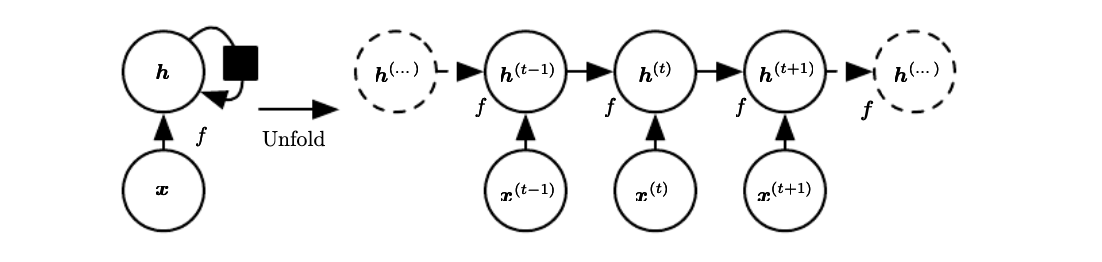

In [5]:
Image('r2.png')

위 그림에서 [왼쪽]에 있는 것이 (1)에 대한 그림이고, [오른쪽]에 있는 것이 (2)에 대한 그림이다.

(1)은 우리가 위에서 알아본 식$h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$를 직접적으로 표현한다. 하지만 펼침unfolding에 의해, 이것은 [오른쪽] 그림 같이 표현될 수 있고, 이것의 식은 또한 다음 같이 기술될 수 있다: t 단계로 펼쳐진 점화식을 $g^{(t)}$라고 해보자. 
$$h^{(t)} = g^{(t)}(x^{(t)}, x^{(t-1)}, ..., x^{(1)})$$  
  
    
Unfolding의 2 가지 이점:  

1. **시퀀스 길이**에 관계없이, **학습된 모델**은 항상 동일한 사이즈를 갖는다. 왜냐하면 이 모델은 "시간 순서에 대한 상태들의 가변적인 길이"가 아닌, "하나의 상태에서 다른 상태로의 전이transition에 의해 명시되기 때문이다.  
  
2. 모든 타임 스텝에서, 동일한 파라미터를 가진, **동일한** 전이 함수 f를 사용하는 것이 가능하다.  
  
이 2 요인 덕분에 모든 타임 스텝에서 개별 모형 $g^{(t)}$를 학습할 필요가 없다. 이 덕분에 (1) 우리는 단지 하나의 공유 모형을 학습시키는 것만으로 트레이닝 셋에서 나타나지 않은 시퀀스 길이의 일반화를 할 수 있고, (2) 파라미터 공유를 하지 않을 때 보다 더 적은 수의 트레이닝 견본example을 가지고 모델을 평가할 수 있다.
  
  


## 2. RNN  


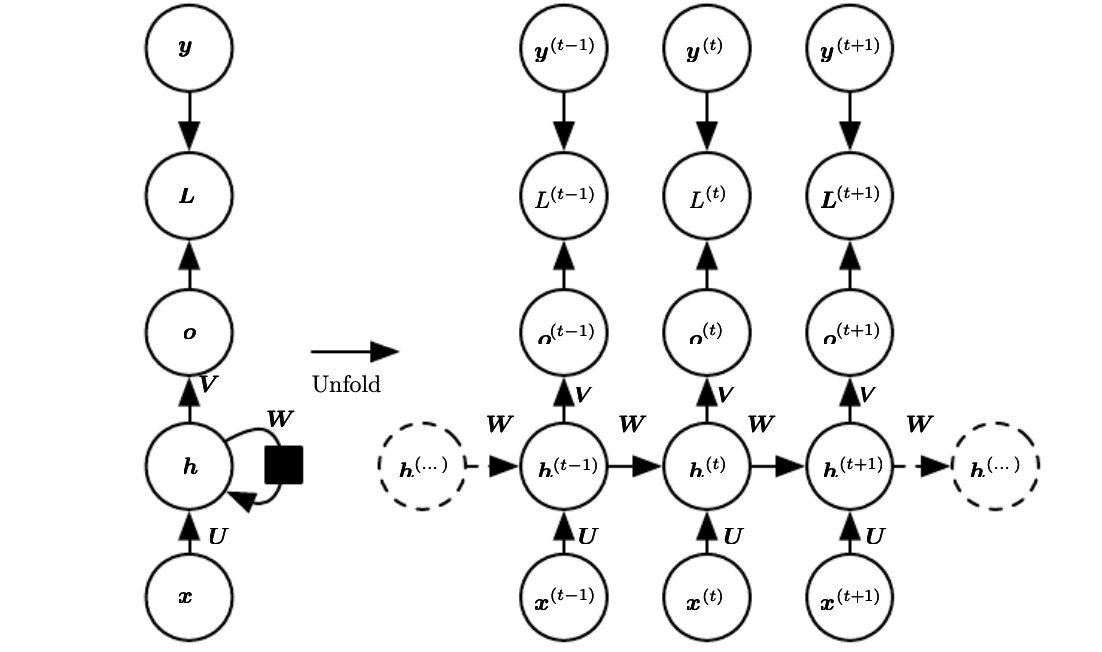

In [24]:
Image('r3.png', width = 800)

### 2.1 <x 입력 순차열>을 <o 출력 순차열>로 사상하는 RNN  
  

  위 그림은 표준적인 RNN 중 하나를 표현한다. 이것은 매 시간-스텝 마다 산출값이 있고, 은닉층들이 서로 순환적으로 연결되는 RNN이다. 튜링 머신에 의해 계산될 수 있는 함수는 이런 유한 크기의 RNN에 의해 계산될 수 있다는 의미에서, 이것은 범용적이다.  
  
손실 L: 각각의 산출값 o가 학습 타겟 y와 얼마나 거리가 먼지를 측정.  
L은 내부적으로 $\hat{y} = softmax(o)$를 계산하고, 이것을 타겟 y와 비교한다.
  
산출값 o: 소프트맥스 산출값을 사용할 때, 우리는 o를 정규화되지 않은 로그 확률이라고 가정한다.  
  
  

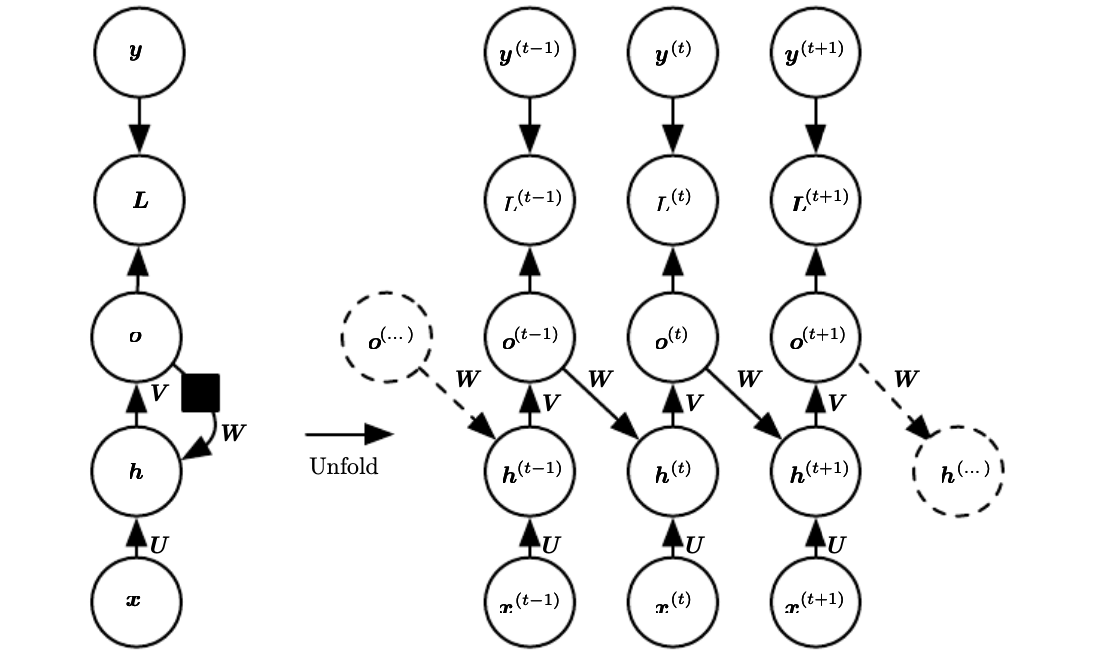

In [26]:
Image('r4.png', width = 800)

### 2.2 순환이 출력층과 은닉층 사이에서 피드백 연결되는 RNN  

- 덜 강력한 RNN. 왜냐하면 이전 RNN 보다, 더 작은 집합의 함수를 표현. 
- 이것은 h가 시간이 지남에 따른 직접적인 연결은 없다. 과거의 h는 오직 간접적으로만 현재와 연결된다.

## 3. 실습 (assignment3.RNN_Captioning)

### 3.0 마운트 및 데이터 로드

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment3'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment3/cs231n/datasets
/content


In [2]:
!pip install h5py

In [3]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

마이크로소프트에서 2014 년에 제공한 COCO 데이터셋을 사용해보자.

In [4]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment3/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


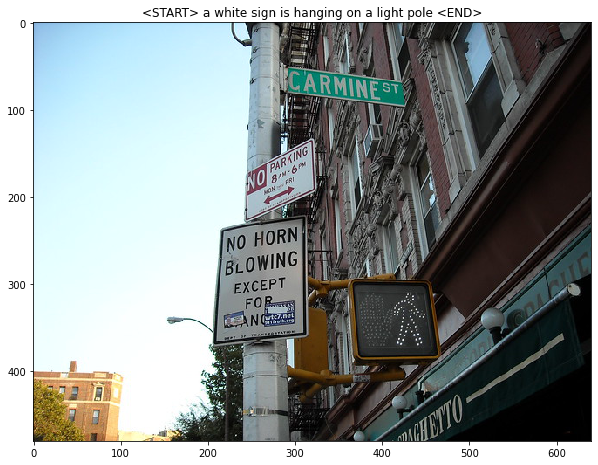

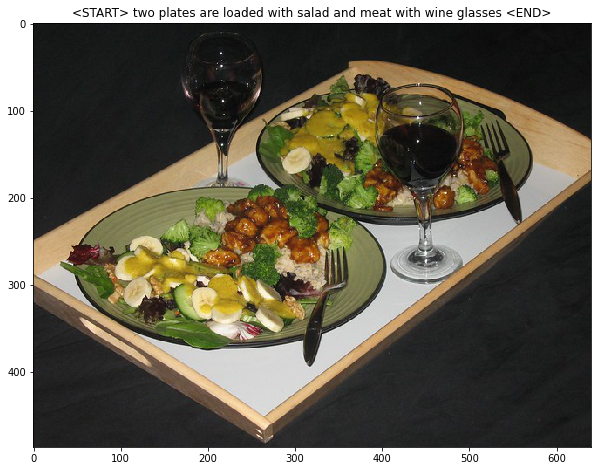

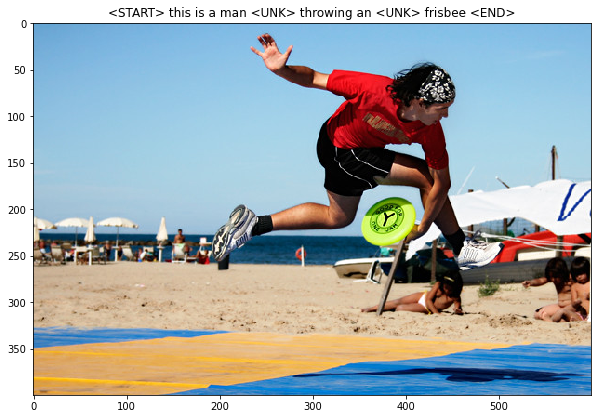

In [5]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('on')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

### 3.1 단일 스텝에 대한 바닐라 RNN

#### 3.1.1 Forward pass

The input data has dimension D, the hidden state has dimension H, and we use a minibatch size of N.

Inputs:
- x: Input data for this timestep, of shape (N, D)  
- prev_h: Hidden state from previous timestep, of shape (N, H)
- Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
- Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
- b: Biases of shape (H,)
  

Returns a tuple of:  
 - next_h: Next hidden state, of shape (N, H)  
 - cache: Tuple of values needed for the backward pass.

In [118]:
from __future__ import print_function, division
from builtins import range
import numpy as np

def rnn_step_forward(x, prev_h, Wx, Wh, b):

    next_h, cache = None, None

    next_h = np.matmul(x,Wx)+np.matmul(prev_h, Wh) + b
    next_h =np.tanh(next_h) #(N, H)

    cache = (x, Wx, prev_h, Wh, next_h)

    return next_h, cache

In [120]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h)) # 요구 오차: e-8 or less

next_h error:  6.292421426471037e-09


#### 3.1.2 Backward pass  


Inputs:  

- dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
- cache: Cache object from the forward pass

Returns a tuple of:  

- dx: Gradients of input data, of shape (N, D)
- dprev_h: Gradients of previous hidden state, of shape (N, H)
- dWx: Gradients of input-to-hidden weights, of shape (D, H)
- dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
- db: Gradients of bias vector, of shape (H,)

            * 일러두기:  
  
          (1) 1 - 행렬 계산
          (2) 원소-곱 연산

In [111]:
import numpy as np

a = np.arange(6).reshape(2,3)
print(a)
print('\n','(1) 1 - 행렬 a: \n\n',1-a)

b = np.arange(6).reshape(2,3)

print('\n (2) element-wise products: \n\n',a*b)

[[0 1 2]
 [3 4 5]]

 (1) 1 - 행렬 a: 

 [[ 1  0 -1]
 [-2 -3 -4]]

 (2) element-wise products: 

 [[ 0  1  4]
 [ 9 16 25]]


#### **복습: tanh 미분** 
  
##### For example, for a = tanh(z),  
the derivatives is this:  


$$da=\ \frac{(e^z+e^{(-z)})d(e^z-e^{(-z)})-(e^z-e^{(-z)})d(e^z+e^{(-z)})}{(e^z+e^{(-z)})²}$$
<br>
$$da=\frac{(e^z+e^{(-z)})(e^z+e^{(-z)})-(e^z-e^{(-z)})(e^z-e^{(-z)})}{(e^z+e^{(-z)})²}$$
<br>
$$da=\frac{(e^z+e^{(-z)})²-(e^z-e^{(-z)})²}{(e^z+e^{(-z)})²}$$
<br>
$$da=1-\frac{(e^z-e^{(-z)})²}{(e^z+e^{(-z)})²}$$ 
<br>
$$da = 1 - a^2$$

In [119]:
def rnn_step_backward(dnext_h, cache):
 
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None

    x, next_h, prev_h, Wx, Wh = cache
    
    dplus_term = dnext_h * (1-next_h**2) # tanh 의 미분 (해설 참고), dnext_h (N, H)

    dx = np.dot(dplus_term, Wx.T) # (N,H) x (H, D) = (N, D)
    dWx = np.matmul(x.T, dplus_term) # (D,N) x (N, H) = (D, H)

    dprev_h = np.matmul(dplus_term, Wh.T) # (N, H) x (H, H) = (N, H)
    dWh = np.matmul(prev_h.T, dplus_term) # (N,H) x (H,H) = (N, H)

    db = np.sum(dplus_term, axis=0) # (H, )

    return dx, dprev_h, dWx, dWh, db


In [121]:
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

ValueError: ignored

### 3.2 Vanila (entire) RNN


전체 시퀀스의 데이터에 대한 RNN 순전파를 실행해보자.  
가정:  
- 차원 D  
- 은닉층 사이즈 H
- N 개 시퀀스를 포함한 미니배치
  
순전파를 작동시킨 뒤, 우리는 모든 타임 스텝의 은닉 상태로 되돌아온다.  

Inputs:
- x: Input data for the entire timeseries, of shape (N, T, D) 
- h0: Initial hidden state, of shape (N, H)
- Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
- Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
- b: Biases of shape (H,)

Returns a tuple of:
- h: Hidden states for the entire timeseries, of shape (N, T, H).
- cache: Values needed in the backward pass
    """

In [ ]:
def rnn_forward(x, h0, Wx, Wh, b):
   
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    h = np.random.randn(x.shape[0], x.shape[1], h0.shape[1])
    h = np.dot(x, Wx) + np.dot(h0, Wh) + b


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [ ]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h)) # 0.7 or less

## References  
  
[1] Ian Goodfellow, Yoshua Bengio, Aaron Courville - Deep Learning-MIT Press (2016)  
[2] 이안 굿펠로우 외, "심층학습", 제이펍(2018), 류광 역  
[3] cs231n 2017 lecture 10  
[4] 오일석, "기계학습", 한빛아카데미 2017